In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm
from style import *
from sklearn import decomposition
import matplotlib.gridspec as grd
import itertools
from sklearn import mixture
from matplotlib_venn import venn3, venn2
import viz

**note: the analysis in this nb can be run for df (the full data) or df2 (the data after removing tracks by lifetime)**

In [ ]:
outcome_def = 'y_consec_sig'
'''        
df = data_tracks.get_tracks() # note: different Xs can be different shapes
df = data_tracks.remove_invalid_tracks(df)
df = data_tracks.preprocess(df)
df = data_tracks.add_outcomes(df)
df2 = data_tracks.remove_tracks_by_lifetime(df, outcome_key=outcome_key, plot=False, acc_thresh=0.90)
df2 = data_tracks.remove_tracks_by_aux_peak_time(df2)
'''

# df2 has already removed everything
df2 = data_tracks.get_data(use_processed=False, use_processed_dicts=False, 
                           outcome_def=outcome_def)

In [7]:
# look at the metadata
metadata_file = 'processed/metadata.pkl'
metadata = pkl.load(open(metadata_file, 'rb'))
for k, v in metadata.items():
    print(k, v)

num_tracks_orig 11414
num_tracks_valid 8707
num_aux_pos_valid 1726
num_short 5809
num_long 190
acc_short 0.8970562919607505
acc_long 0.9
thresh_short 37
thresh_long 129
num_tracks_after_lifetime 1595
num_aux_pos_after_lifetime 957
num_tracks_after_peak_time 1434
num_aux_pos_after_peak_time 889


# visualize outcomes
- take mean, take sigma, define events with a threshold

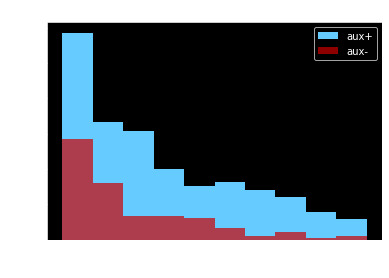

In [4]:
outcome = df2[outcome_def]
aux_pos = df2['lifetime'][outcome==1] 
aux_neg = df2['lifetime'][outcome==0] 
plt.hist(aux_pos, label='aux+', alpha=1, color=cb)
plt.hist(aux_neg, label='aux-', alpha=0.7, color=cr)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title(f'aux+: {aux_pos.shape[0]}, aux-: {aux_neg.shape[0]}, tot: {df2.shape[0]}')
plt.legend()
plt.show()

In [14]:
def sort_outcome(df, outcome_def):
    outcome_score = df['Y_max'].values
    idxs_sort = np.argsort(outcome_score)
    return df[outcome_def].values[idxs_sort], df['Y'].values[idxs_sort]

# outcome_sort, Y_sort = sort_outcome(df, outcome_key='y_thresh')
outcome_sort, Y_sort = sort_outcome(df2, outcome_def)

**top and bottom**

In [ ]:
R, C = 4, 5
# plt.figure(dpi=200)
plt.figure(figsize=(9, 8), dpi=200)
n = Y_sort.shape[0]
idxs = list(range(10)) + list(range(n - 10, n))
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='green') #color=cr if outcome_sort[idx] == 0 else cb)
#     plt.axis('off')
plt.tight_layout()

**around the thresh**

In [ ]:
R, C = 8, 10
# plt.figure(dpi=200)
plt.figure(figsize=(18, 12))
idxs = list(range(num_neg - 40, num_neg + 40)) # let's look at ones in the middle
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color='blue' if outcome_sort[idx] == 0 else 'orange')
#     plt.axis('off')
plt.tight_layout()

**compare different outcome defs**

In [ ]:
keys = ['y_thresh', 'y_single_sig', 'y_double_sig', 'y_consec_sig', 'y']
mat = df[keys] #.corr()# make fig
# plt.figure(dpi=200)
# sns.heatmap(mat.corr(method='spearman'), annot=True,
#             cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), vmin=-1, vmax=1)
# plt.show()

plt.figure(dpi=200)
sns.barplot(x=keys, y=mat.sum(), color=cb, alpha=1)
plt.ylabel('num aux+')
plt.xlabel('aux+ definition')

In [ ]:
plt.figure(dpi=200)
idxs = np.arange(df.shape[0])
keys = ['y_thresh', 'y_single_sig', 'y_consec_sig']
venn3([set(idxs[df[keys[0]] == 1]), set(idxs[df[keys[1]] == 1]), set(idxs[df[keys[2]] == 1])], keys)
plt.show()

In [ ]:
plt.figure(dpi=200)
idxs = np.arange(df.shape[0])
keys = ['y_single_sig', 'y_thresh']
venn2([set(idxs[df[keys[0]] == 1]), set(idxs[df[keys[1]] == 1])], keys[:2])
plt.show()

**compare as a func of aux_max**

In [ ]:
R, C = 20, 28
# plt.figure(dpi=200)
plt.figure(figsize=(28, 20))
n = Y_sort.shape[0] # 1434

idxs = np.array([np.arange(int(i), int(i) + C) for i in np.linspace(0, n - C, R)]).flatten() #list(range(10)) + list(range(n - 10, n))
Ys = Y_sort[idxs]
ymin = -200
ymax = 4000

for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Ys[i], color=cr if outcome_sort[idx] == 0 else cb, lw=1)
    plt.ylim((ymin - 1, ymax + 1))
    plt.xlim((0, 120))
    if not i == R * C - C:
        plt.yticks([])
        plt.xticks([])
#     plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('def.pdf')

In [ ]:
aux_plus = df2[outcome_def] == 1
plt.hist(df2[aux_plus]['Y_max'], color=cb, label='aux+', bins=100)
plt.hist(df2[~aux_plus]['Y_max'], color=cr, label='aux-', alpha=0.7, bins=100)
plt.xlabel('aux_max')
plt.ylabel('count')
plt.legend()
plt.show()

# viz tracks where auxilin peaks first

In [ ]:
outcomes = ['y_consec_sig'] # ['y_thresh', 'y_single_sig', 'y_consec_sig']
for outcome in outcomes:
    X_peak_idx = df2['X_peak_idx'] #np.array([np.argmax(x) for x in df2.X])
    Y_peak_idx = df2['Y_peak_idx'] # np.array([np.argmax(y) for y in df2.Y])
    idxs_err = Y_peak_idx < X_peak_idx
    df_err = df2[idxs_err]
    df_err_pos = df_err[df_err[outcome] == 1]
    num_pos = df2[df2[outcome] == 1].shape[0]
    num_pos_err = df_err_pos.shape[0] 
    frac_pos_err = num_pos_err / num_pos
    print('num tot', df2.shape[0], 'num aux peaks first', df_err.shape[0], f'frac pos aux peaks first {frac_pos_err:0.3f}')
    viz.plot_curves(df_err_pos)

In [ ]:
plt.figure(dpi=300)
plt.hist(df_err_pos.lifetime, bins=20, color=cb)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title('aux+ with auxilin peaking first')
plt.show()

In [ ]:
R, C = 2, 1
plt.figure(dpi=200)
plt.subplot(R, C, 1)
plt.hist(X_peak_idx[idxs_err], color=cr)
plt.xlabel('Clathrin peak time')
plt.ylabel('Count')
plt.subplot(R, C, 2)
plt.hist(Y_peak_idx[idxs_err], color=cr)
plt.xlabel('Auxilin peak time')
plt.ylabel('Count')
plt.tight_layout()

# analyze aux+ p-value / amplitude defs

In [4]:
aux = df.Y
aux_p = df.Y_pvals

ys = np.array(list(itertools.chain.from_iterable(aux)))
ps = np.array(list(itertools.chain.from_iterable(aux_p.values)))

ps_sig = ps < 0.05

In [ ]:
R = 1
C = 2
plt.figure(figsize=(8, 4), dpi=200)
plt.subplot(R, C, 1)
plt.hist(ps, bins=100, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
plt.yscale('log')
plt.axvline(0.05, color=cr)
plt.xlabel('auxilin p-value')
plt.ylabel('count (log-scale)')
# plt.xscale('log')
# plt.ylabel()
# plt.xlim((0, 0.1))
print(f'num sig {np.sum(ps_sig):,d}')
print(f'num nonsig {np.sum(~ps_sig):,d}')

plt.subplot(R, C, 2)
ys_sig = ys[ps_sig]
(counts, bins, _) = plt.hist(ys_sig, bins=180, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
idx_max = np.argmax(counts)
aux_max = bins[idx_max]
plt.axvline(aux_max, color=cr)
plt.xlabel('auxilin amplitude')
plt.ylabel('count')
plt.tight_layout()
plt.show()

print('aux_max', aux_max)

In [ ]:
ys_sig = ys_sig.reshape(-1, 1)
mog = mixture.GaussianMixture(n_components=3)
mog.fit(ys_sig.reshape(-1, 1))
preds = mog.predict(ys_sig.reshape(-1, 1))

# plot hist
plt.figure(dpi=200)
plt.hist(ys_sig, bins=bins, alpha=1, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
samples, comps = mog.sample(n_samples=ys_sig.size) 
for i in [0, 2, 1]:
    idxs = comps==i
    plt.hist(samples[idxs], bins=bins, alpha=0.75, label=f'{mog.means_[i, 0]}')
plt.axvline(aux_max, color='white')
# plt.legend()

plt.xlabel('auxilin amplitude (significant only)')
plt.ylabel('count')
plt.show()